In [1]:
import pandas as pd
import numpy as np

# Plot packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# Pre-processing packages
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Packages for handling missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
import lazypredict
from lazypredict.Supervised import LazyClassifier


# Models 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Model optimization package
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


In [3]:
data = pd.read_csv("C:/Users/nambi/Downloads/bank.csv",sep = ',')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [5]:
miss_val = data.isnull().any().sum()
miss_val

0

In [6]:
data_categorical = data.select_dtypes(include='object')
data_numeric = data.select_dtypes(include='int64')
col_cat = data_categorical.columns 
col_num = data_numeric.columns

In [7]:
data[col_num].describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00
mean,41.23,1528.54,15.66,371.99,2.51,51.33,0.83
std,11.91,3225.41,8.42,347.13,2.72,108.76,2.29
min,18.00,-6847.00,1.00,2.00,1.00,-1.00,0.00
25%,32.00,122.00,8.00,138.00,1.00,-1.00,0.00
50%,39.00,550.00,15.00,255.00,2.00,-1.00,0.00
75%,49.00,1708.00,22.00,496.00,3.00,20.75,1.00
max,95.00,81204.00,31.00,3881.00,63.00,854.00,58.00


In [8]:
data['balance_range'] = pd.cut(data['balance'], bins=[5000,10000,20000,40000, np.inf], labels=['5000_to_10000','10000_to_20000','20000_to_40000','over_40000']) 
aux = data.groupby(['balance_range','deposit']).count()
aux['value'] = round(aux.iloc[:,0]*100/data.shape[0],2).to_frame()
aux.reset_index(inplace=True)
fig = px.bar(aux, x='balance_range', y = 'value', color='deposit', height=800,width=800,text = 'value')
fig.update_traces(textfont_size=20, textangle=0, textposition="outside")
fig.update_layout(title_text = "Distribution of balance", 
                       yaxis = dict(title='Percentage of data',titlefont_size=16,tickfont_size=14),
                       xaxis = dict(title='balance',titlefont_size=16,tickfont_size=14))
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [9]:
data.drop(data[data.balance>20000].index, inplace=True)
data.reset_index(inplace = True, drop =True)
data.drop('balance_range', axis=1, inplace = True)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11100,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11101,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11102,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11103,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [10]:
def test_miss_validation(dataframe, miss_name_col,corr_name_col):
    rows = []
    for i in miss_name_col:
        cols = []
        for j in corr_name_col:
            miss_val = dataframe[dataframe[i]==False].groupby(j)[i].count()
            true_val = dataframe[dataframe[i]==True].groupby(j)[i].count()
            
            # Checking if the two lists have the same number of categories
            len_1 = len(true_val)
            len_2 = len(miss_val)
            if len_1 <len_2:
                mux = tuple(miss_val.index)
                true_val = true_val.reindex(mux, fill_value=0)
            if len_1 >=len_2:
                mux = tuple(true_val.index)
                miss_val = miss_val.reindex(mux, fill_value=0)
            
            
            table_validation = np.transpose([true_val.values, miss_val.values])
            p_value = chi2_contingency(table_validation)[1]
            cols.append(round(p_value,6))
        
        rows.append(cols)
    
    t_results = np.array(rows)
    df = pd.DataFrame(t_results, columns = corr_name_col, index =miss_name_col)
    return df


In [11]:
miss_names = ['poutcome_miss','contact_miss']
cat_test = col_cat.to_list()
cat_test.remove('poutcome')
cat_test.remove('contact')

data['poutcome_miss'] = data['poutcome']
data['poutcome_miss'] = False
data.loc[data[data['poutcome'].isnull()].index, "poutcome_miss"] = True 
##

data['contact_miss'] = data['contact']
data['contact_miss'] = False
data.loc[data[data['contact'].isnull()].index, "contact_miss"] = True

In [12]:
data[col_cat].head()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
0,admin.,married,secondary,no,yes,no,unknown,may,unknown,yes
1,admin.,married,secondary,no,no,no,unknown,may,unknown,yes
2,technician,married,secondary,no,yes,no,unknown,may,unknown,yes
3,services,married,secondary,no,yes,no,unknown,may,unknown,yes
4,admin.,married,tertiary,no,no,no,unknown,may,unknown,yes


In [13]:
data_encoded = data.copy()
data_encoded.drop(columns = ['poutcome_miss','contact_miss'],inplace=True)
data_encoded = pd.get_dummies(data_encoded, columns = ['job', 'marital'])
data_encoded.head()

,age,education,default,balance,housing,loan,contact,day,month,duration,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,59,secondary,no,2343,yes,no,unknown,5,may,1042,...,0,0,0,0,0,0,0,0,1,0
1,56,secondary,no,45,no,no,unknown,5,may,1467,...,0,0,0,0,0,0,0,0,1,0
2,41,secondary,no,1270,yes,no,unknown,5,may,1389,...,0,0,0,0,1,0,0,0,1,0
3,55,secondary,no,2476,yes,no,unknown,5,may,579,...,0,0,1,0,0,0,0,0,1,0
4,54,tertiary,no,184,no,no,unknown,5,may,673,...,0,0,0,0,0,0,0,0,1,0


In [14]:
data_encoded['education'] = data_encoded['education'].astype('category')
data_encoded['education']=data_encoded['education'].cat.codes
data_encoded['education']

0        1
1        1
2        1
3        1
4        2
        ..
11100    0
11101    1
11102    1
11103    1
11104    1
Name: education, Length: 11105, dtype: int8

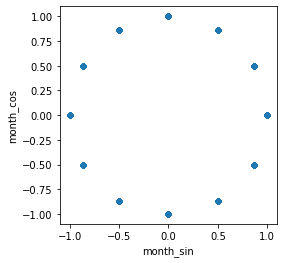

In [15]:
label_encoder = LabelEncoder()
data_encoded['month'] = label_encoder.fit_transform(data_encoded['month'])+1 # usando label encoder ele começa a transformação usando 0 não o 1

# Transformando a variável 'month' em sin e cos
max_val = data_encoded['month'].max()
data_encoded['month_sin'] = np.sin(2 * np.pi *data_encoded['month']/max_val)
data_encoded['month_cos'] = np.cos(2 * np.pi * data_encoded['month']/max_val)

# Transformando a variável 'day' em sin e cos
max_val = data_encoded['day'].max()
data_encoded['day_sin'] = np.sin(2 * np.pi *data_encoded['day']/max_val)
data_encoded['day_cos'] = np.cos(2 * np.pi * data_encoded['day']/max_val)

data_encoded.drop(columns = ['day','month'],inplace=True)

ax = data_encoded.plot.scatter('month_sin', 'month_cos').set_aspect('equal')


In [16]:
name_cat =col_cat.to_list()
name_cat.remove('education')
name_cat.remove('job')
name_cat.remove('marital')
name_cat.remove('month')

data_encoded['poutcome'] = data_encoded['poutcome'].replace({np.NaN:'unknown'})
data_encoded['contact'] = data_encoded['contact'].replace({np.NaN:'unknown'})

label_encoder = LabelEncoder()

for i in name_cat:
    data_encoded[i] = label_encoder.fit_transform(data_encoded[i])
    
data_encoded['poutcome'].value_counts()

3    8285
0    1225
2    1064
1     531
Name: poutcome, dtype: int64

In [17]:
data_encoded['poutcome'] = data_encoded['poutcome'].replace(2,np.NaN)
data_encoded['contact'] = data_encoded['contact'].replace(2,np.NaN)

In [18]:
scaler = MinMaxScaler()
data_scaler = pd.DataFrame(scaler.fit_transform(data_encoded), columns = data_encoded.columns)
data_scaler.drop(columns = ['deposit'],inplace=True)
data_scaler.head()

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,...,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,month_sin,month_cos,day_sin,day_cos
0,0.53,0.33,0.00,0.35,1.00,0.00,NaN,0.27,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.50,0.92,0.76
1,0.49,0.33,0.00,0.26,0.00,0.00,NaN,0.38,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.50,0.92,0.76
2,0.30,0.33,0.00,0.31,1.00,0.00,NaN,0.36,0.00,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.50,0.92,0.76
3,0.48,0.33,0.00,0.35,1.00,0.00,NaN,0.15,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.50,0.92,0.76
4,0.47,0.67,0.00,0.27,0.00,0.00,NaN,0.17,0.02,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.50,0.92,0.76


In [19]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=1000,random_state=0,n_nearest_features=None)

data_end = pd.DataFrame(imputer.fit_transform(data_scaler),columns = data_scaler.columns)

data_end['poutcome'] = data_end['poutcome'].round(decimals=0)
data_end['contact'] = data_end['contact'].round(decimals=0)
data_end['poutcome'].value_counts()

1.00     8754
0.00     2347
-1.00       4
Name: poutcome, dtype: int64

In [20]:
data_end['contact'].value_counts()

0.00    10339
1.00      766
Name: contact, dtype: int64

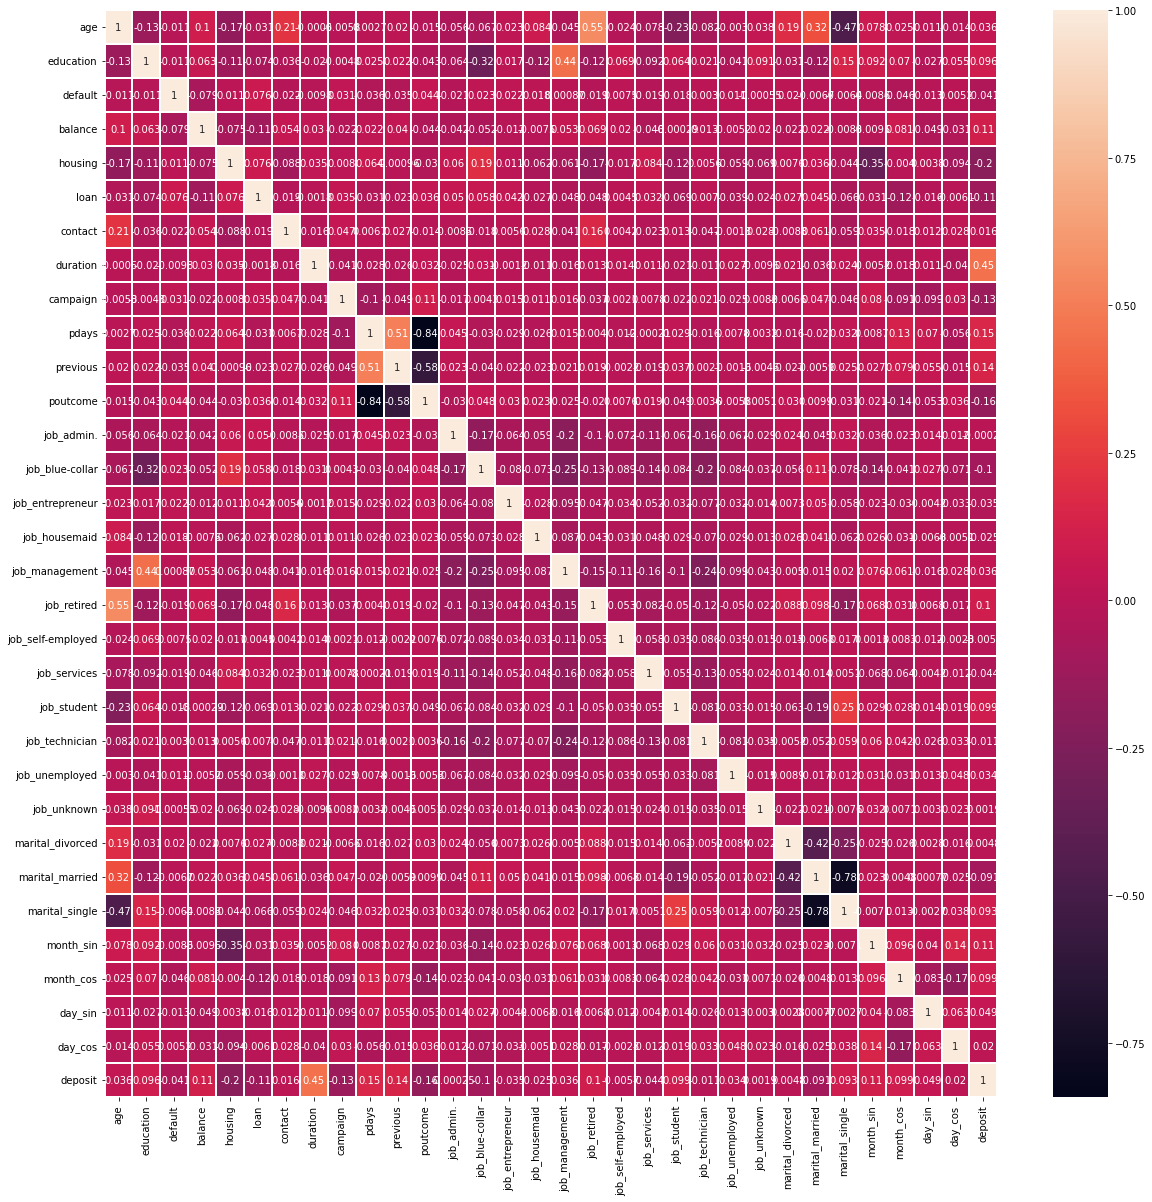

In [21]:
data_end['deposit'] = data_encoded['deposit']
fig, axes = plt.subplots(1, figsize=(20,20))
pearson_matrix = data_end.corr(method='pearson')
fig = sns.heatmap(pearson_matrix, annot=True,linewidths=.1)


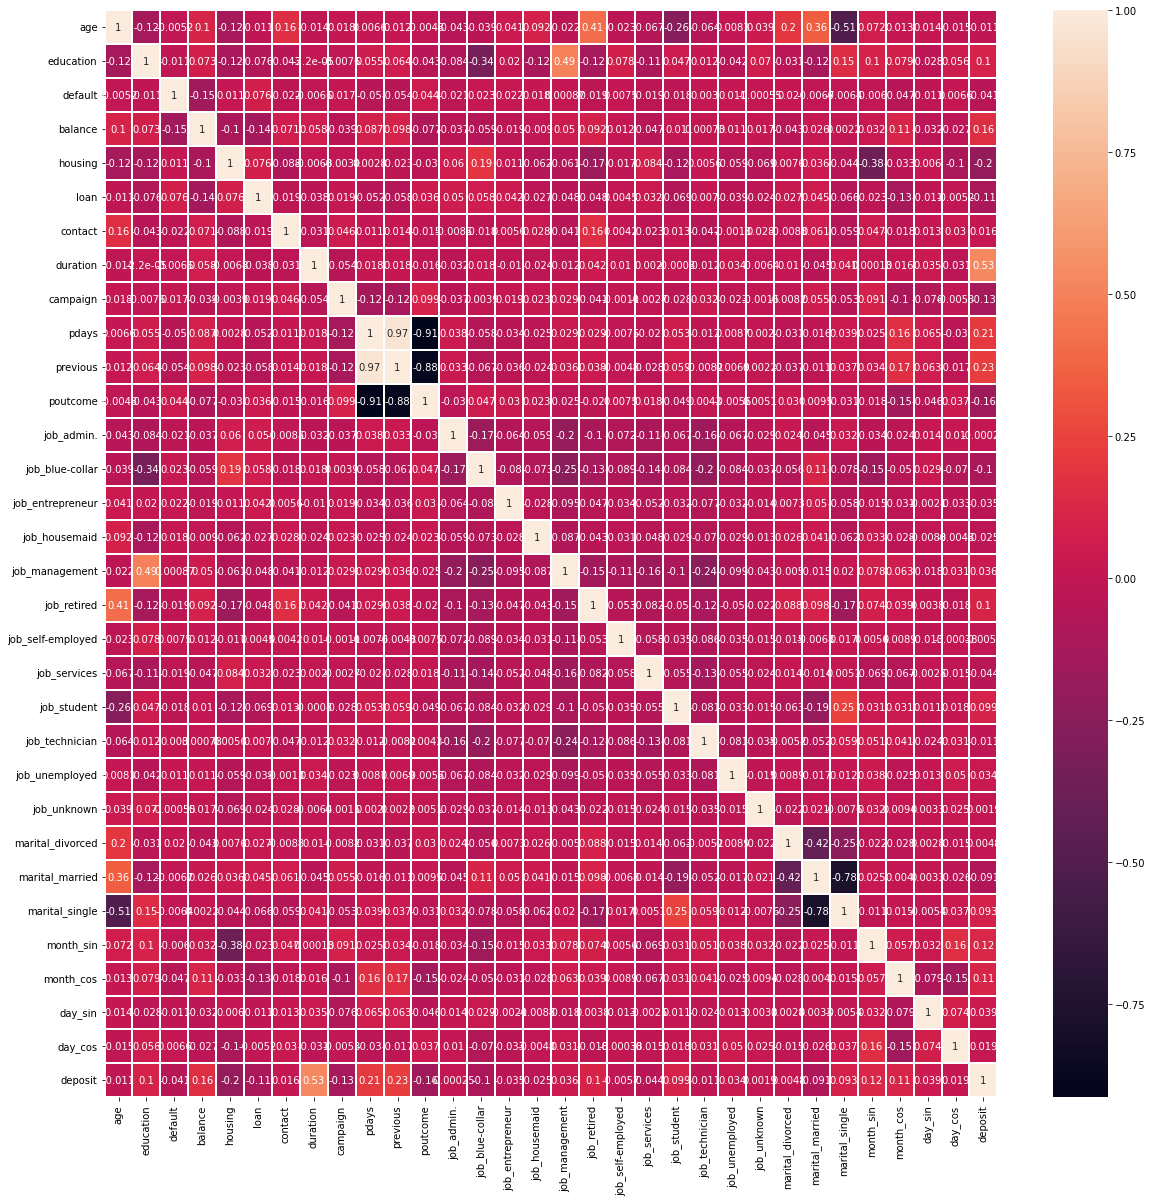

In [22]:
axes = plt.subplots(1, figsize=(20,20))
spearman_matrix = data_end.corr(method='spearman')
fig = sns.heatmap(spearman_matrix, annot=True,linewidths=.1)

In [23]:
data_end.drop(columns=['pdays','marital_single','deposit'],inplace = True)

In [24]:
X = data_end
y= data_encoded['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =0)

In [25]:
lazy_model = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=precision_score)
models,predictions = lazy_model.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,precision_score,Time Taken
Model,,,,,,
RandomForestClassifier,0.84,0.84,0.84,0.84,0.82,1.23
XGBClassifier,0.84,0.84,0.84,0.84,0.82,2.41
LGBMClassifier,0.83,0.84,0.84,0.83,0.79,0.23
ExtraTreesClassifier,0.83,0.83,0.83,0.83,0.81,1.45
BaggingClassifier,0.82,0.82,0.82,0.82,0.81,0.70
AdaBoostClassifier,0.81,0.81,0.81,0.81,0.80,0.78
SVC,0.80,0.80,0.80,0.80,0.79,4.70
NuSVC,0.80,0.80,0.80,0.80,0.79,5.88
CalibratedClassifierCV,0.78,0.78,0.78,0.78,0.78,7.26


Random Forest 

In [26]:
from sklearn.ensemble import RandomForestClassifier
def RF(X_train, y_train, X_test, y_test, input_data):#random forest
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)

    input_data = np.array(input_data).reshape(1, -1) # reshape input data to a single row
    prediction = model.predict(input_data)
    
    return accuracy, prediction

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
def XG(X_train, y_train, X_test, y_test, input_data):
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    input_data = np.array(input_data).reshape(1, -1) # reshape input data to a single row
    prediction = model.predict(input_data)
    
    return accuracy, prediction


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

def LR(X_train, y_train, X_test, y_test, input_data):
    model = LogisticRegression()

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Make prediction for input data
    input_data = np.array(input_data).reshape(1, -1) # reshape input data to a single row
    prediction = model.predict(input_data)
    
    return accuracy, prediction


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def KN(X_train, y_train, X_test, y_test, input_data):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Make prediction for input data
    input_data = np.array(input_data).reshape(1, -1) # reshape input data to a single row
    prediction = model.predict(input_data)
    
    return accuracy, prediction


In [30]:
input_data = [0.00, 0.00, 0, 0.00, 0, 0, 0, 0.00, 1, 0.09,0, 0, 0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0 ,0, 0]

# Call the KN() function with input data
accuracy, prediction = KN(X_train, y_train, X_test, y_test, input_data)
print("Accuracy:", accuracy)
print("Prediction:", prediction)

accuracy, prediction = LR(X_train, y_train, X_test, y_test, input_data)

# Print the accuracy score and prediction
print("Accuracy:", accuracy)
print("Prediction:", prediction)

accuracy, prediction = RF(X_train, y_train, X_test, y_test, input_data)

# Print the accuracy score and prediction
print("Accuracy:", accuracy)
print("Prediction:", prediction)

accuracy, prediction = XG(X_train, y_train, X_test, y_test, input_data)

# Print the accuracy score and prediction
print("Accuracy:", accuracy)
print("Prediction:", prediction)

Accuracy: 0.6537595677622693
Prediction: [1]
Accuracy: 0.7735254389914453
Prediction: [0]
Accuracy: 0.8446645655110311
Prediction: [0]
Accuracy: 0.8397118415128321
Prediction: [0]


In [32]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_1 = KNeighborsClassifier(n_neighbors=5)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

model_2 = LogisticRegression()
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

model_3 = RandomForestClassifier()
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)

import pickle
with open('model.pkl','wb') as files:
    pickle.dump(model,files)

with open('model_1.pkl','wb') as files:
    pickle.dump(model_1,files)

with open('model_2.pkl','wb') as files:
    pickle.dump(model_2,files)

with open('model_3.pkl','wb') as files:
    pickle.dump(model_2,files)
